In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
# Set dataset directories
base_dir = "/kaggle/input/rsbdsl38/RSBDSL38_ver01/RSBDSL38_resized_splitted"  # Change this to your dataset path
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Image parameters
img_size = (224, 224)
batch_size = 32

# ImageDataGenerator for real-time data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 7592 images belonging to 38 classes.
Found 1633 images belonging to 38 classes.
Found 1649 images belonging to 38 classes.


In [3]:
# Load MobileNetV2 model (excluding top layers)
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)  # Add dropout for regularization
predictions = Dense(38, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_loss',   # Stops when val_loss stops improving
    patience=5,           # Stop if val_loss doesn't improve for 3 epochs
    min_delta=0.001,      # Ignore very small changes
    restore_best_weights=True,  
    verbose=1  # Prints a message when stopping
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-7, 
    verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.0427 - loss: 3.7912 - val_accuracy: 0.1788 - val_loss: 3.1943 - learning_rate: 1.0000e-05
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 93s 377ms/step - accuracy: 0.1523 - loss: 3.1933 - val_accuracy: 0.4887 - val_loss: 2.2825 - learning_rate: 1.0000e-05
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 92s 374ms/step - accuracy: 0.3664 - loss: 2.4616 - val_accuracy: 0.6895 - val_loss: 1.5113 - learning_rate: 1.0000e-05
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 91s 372ms/step - accuracy: 0.5476 - loss: 1.7726 - val_accuracy: 0.7777 - val_loss: 1.0320 - learning_rate: 1.0000e-05
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 91s 373ms/step - accuracy: 0.6693 - loss: 1.2954 - val_accuracy: 0.8212 - val_loss: 0.7446 - learning_rate: 1.0000e-05
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 92s 375ms/step - accuracy: 0.7299 - loss: 1.0204 - val_accuracy: 0.8561 - val_loss: 0.5741 - learning_rate: 1.0000e-05
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 9

In [5]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model
model.save("mobilenetv2_garbage_classifier.keras")

52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.9645 - loss: 0.1357
Test Accuracy: 0.9697


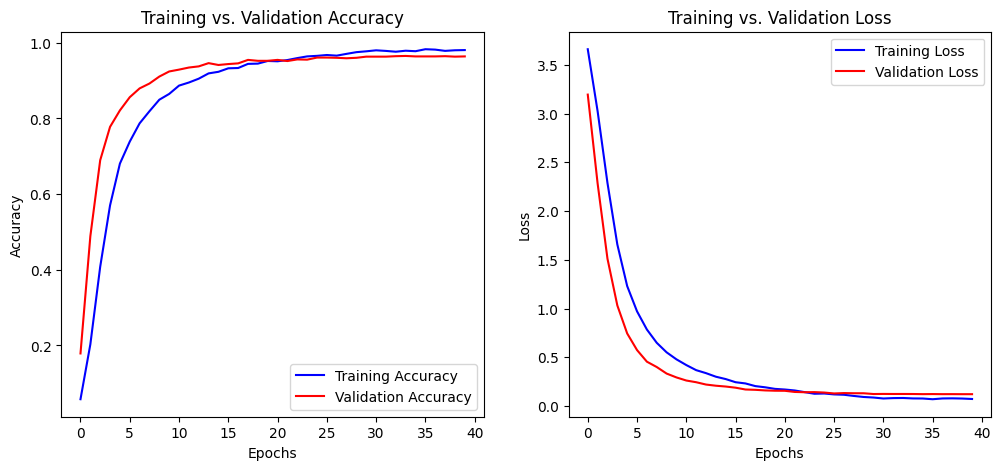

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


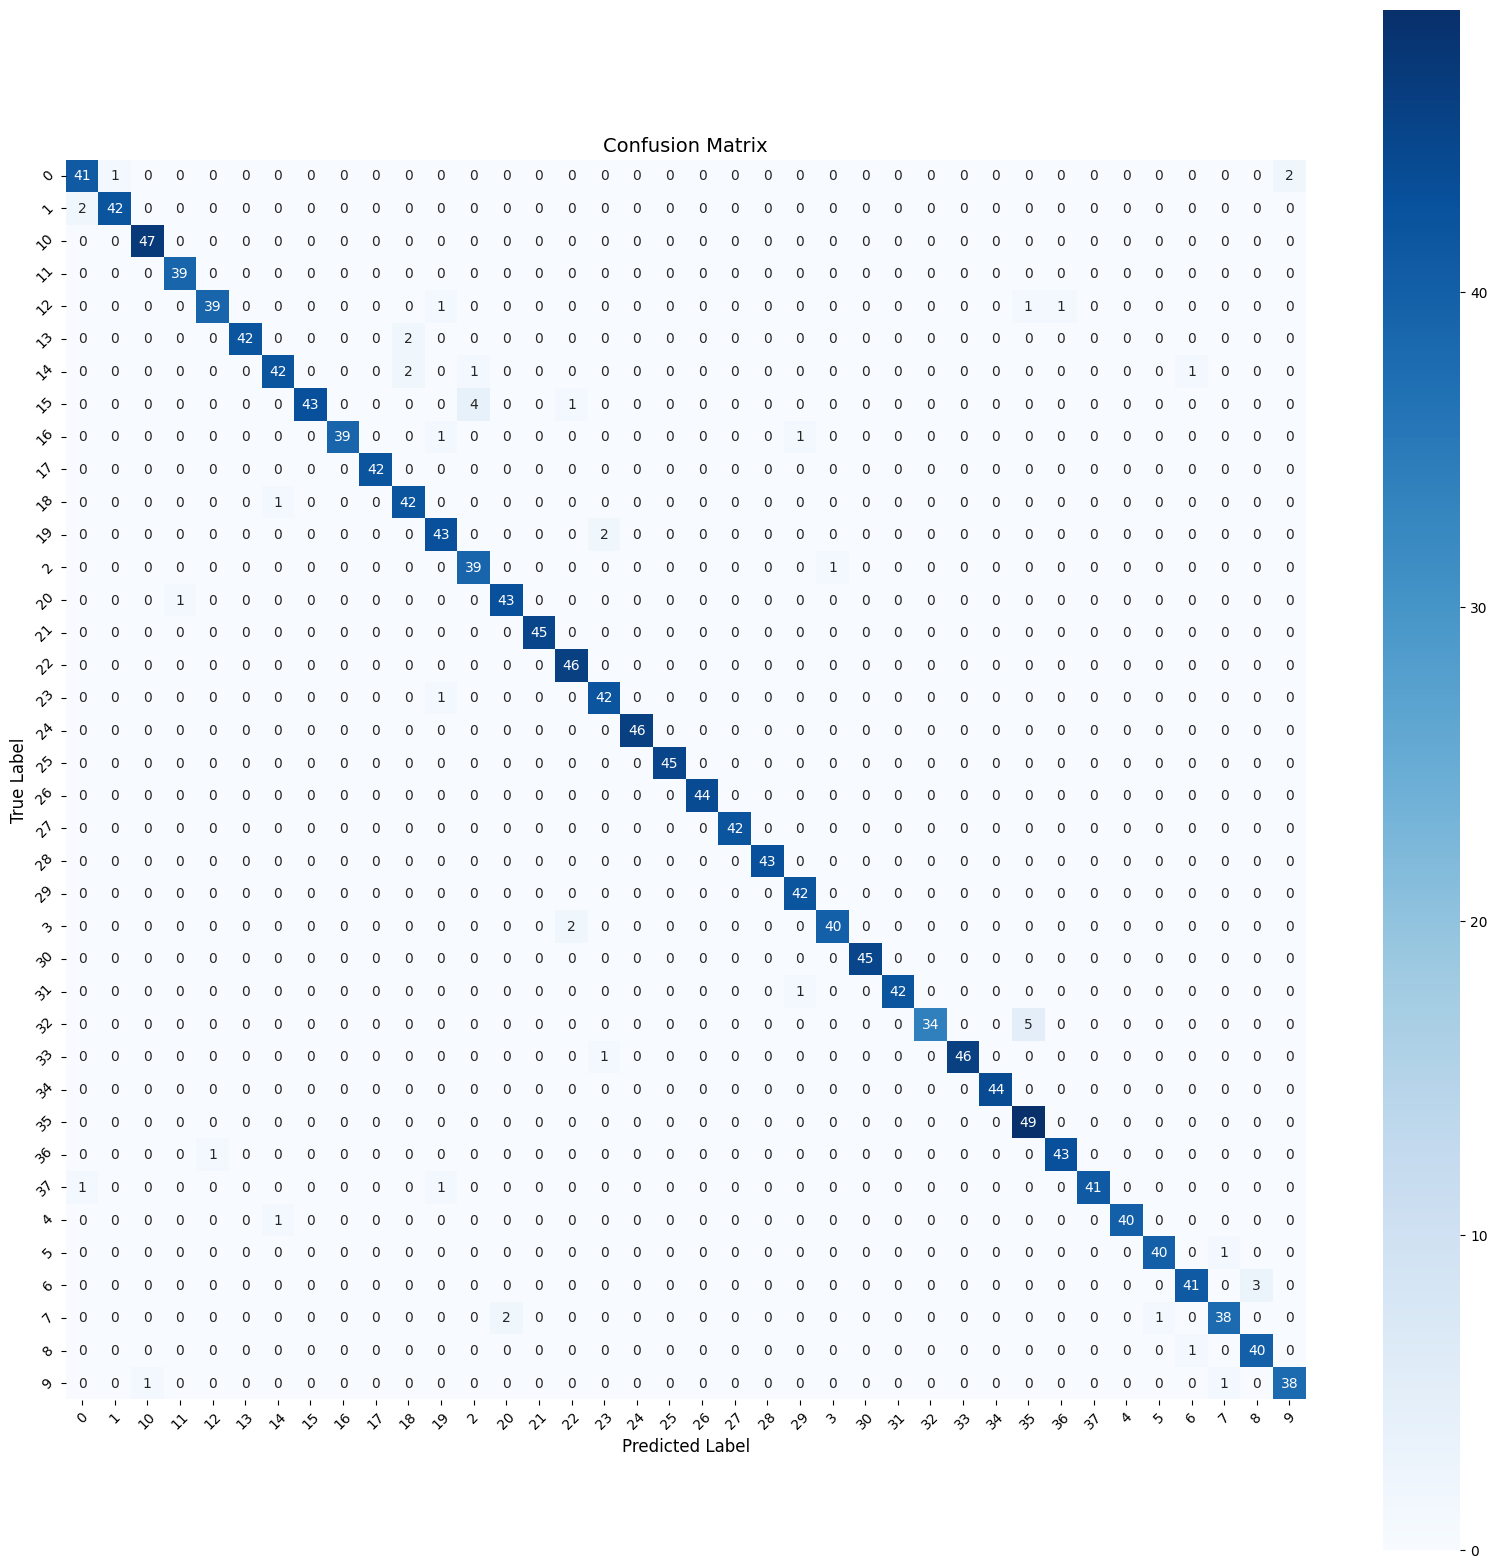


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        44
           1       0.98      0.95      0.97        44
          10       0.98      1.00      0.99        47
          11       0.97      1.00      0.99        39
          12       0.97      0.93      0.95        42
          13       1.00      0.95      0.98        44
          14       0.95      0.91      0.93        46
          15       1.00      0.90      0.95        48
          16       1.00      0.95      0.97        41
          17       1.00      1.00      1.00        42
          18       0.91      0.98      0.94        43
          19       0.91      0.96      0.93        45
           2       0.89      0.97      0.93        40
          20       0.96      0.98      0.97        44
          21       1.00      1.00      1.00        45
          22       0.94      1.00      0.97        46
          23       0.93      0.98      0.95        43
  

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot training accuracy & loss curves
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs. Validation Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs. Validation Loss")

    plt.show()

# Call function to plot accuracy & loss curves
plot_training(history)

# Get true labels and class names
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())  

# Get model predictions
y_pred_probs = model.predict(test_generator)  # Probability outputs
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with Seaborn
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, cbar=True, square=True)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.yticks(rotation=45)
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))